In [22]:
from __future__ import annotations

import operator
import os
import re
from datetime import date, datetime, timedelta
from pathlib import Path
from typing import TypedDict, List, Optional, Literal, Annotated

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_aws import ChatBedrockConverse
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults


In [23]:
# -----------------------------
# 1) Schemas
# -----------------------------
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=6,
        description="3–6 concrete, non-overlapping subpoints to cover in this section.",
    )
    target_words: int = Field(..., description="Target word count for this section (120–550).")

    tags: List[str] = Field(default_factory=list)
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False


class Plan(BaseModel):
    blog_title: str
    audience: str
    tone: str

    # NEW: tells workers what genre this is (prevents drift)
    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"

    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task]


class EvidenceItem(BaseModel):
    title: str
    url: str
    published_at: Optional[str] = None  # prefer ISO "YYYY-MM-DD"
    snippet: Optional[str] = None
    source: Optional[str] = None


class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal["closed_book", "hybrid", "open_book"]
    reason: str
    queries: List[str] = Field(default_factory=list)
    max_results_per_query: int = Field(5, description="How many results to fetch per query (3–8).")


class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(default_factory=list)


In [24]:
class State(TypedDict):
    topic: str

    # routing / research
    mode: str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    plan: Optional[Plan]

    # NEW: recency control
    as_of: str           # ISO date, e.g. "2026-01-29"
    recency_days: int    # 7 for weekly news, 30 for hybrid, etc.

    # workers
    sections: Annotated[List[tuple[int, str]], operator.add]  # (task_id, section_md)
    final: str


In [25]:
# -----------------------------
# 2) LLM
# -----------------------------
llm = ChatBedrockConverse(
    model="us.anthropic.claude-sonnet-4-5-20250929-v1:0",
    region_name=os.getenv("AWS_DEFAULT_REGION"),
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY"), # Use variables here
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
)

In [26]:
# -----------------------------
# 3) Router (decide upfront)
# -----------------------------
ROUTER_SYSTEM = """You are a routing module for a technical blog planner.

Decide whether web research is needed BEFORE planning.

Modes:
- closed_book (needs_research=false):
  Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
- hybrid (needs_research=true):
  Mostly evergreen but needs up-to-date examples/tools/models to be useful.
- open_book (needs_research=true):
  Mostly volatile: weekly roundups, "this week", "latest", rankings, pricing, policy/regulation.

If needs_research=true:
- Output 3–10 high-signal queries.
- Queries should be scoped and specific (avoid generic queries like just "AI" or "LLM").
- For open_book weekly roundup, include queries that reflect the last 7 days constraint.
"""

def router_node(state: State) -> dict:
    topic = state["topic"]
    decider = llm.with_structured_output(RouterDecision)
    decision = decider.invoke(
        [
            SystemMessage(content=ROUTER_SYSTEM),
            HumanMessage(content=f"Topic: {topic}\nAs-of date: {state['as_of']}"),
        ]
    )

    # Set default recency window based on mode
    if decision.mode == "open_book":
        recency_days = 7
    elif decision.mode == "hybrid":
        recency_days = 45
    else:
        recency_days = 3650

    return {
        "needs_research": decision.needs_research,
        "mode": decision.mode,
        "queries": decision.queries,
        "recency_days": recency_days,
    }

def route_next(state: State) -> str:
    return "research" if state["needs_research"] else "orchestrator"


In [27]:
# -----------------------------
# 4) Research (Tavily)
# -----------------------------
def _tavily_search(query: str, max_results: int = 5) -> List[dict]:
    """
    Uses TavilySearchResults if installed and TAVILY_API_KEY is set.
    Returns list of dict with common fields. Note: published date is often missing.
    """
    tool = TavilySearchResults(max_results=max_results)
    results = tool.invoke({"query": query})

    normalized: List[dict] = []
    for r in results or []:
        normalized.append(
            {
                "title": r.get("title") or "",
                "url": r.get("url") or "",
                "snippet": r.get("content") or r.get("snippet") or "",
                "published_at": r.get("published_date") or r.get("published_at"),
                "source": r.get("source"),
            }
        )
    return normalized


def _iso_to_date(s: Optional[str]) -> Optional[date]:
    if not s:
        return None
    try:
        return date.fromisoformat(s[:10])
    except Exception:
        return None


RESEARCH_SYSTEM = """You are a research synthesizer for technical writing.

Given raw web search results, produce a deduplicated list of EvidenceItem objects.

Rules:
- Only include items with a non-empty url.
- Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
- Extract/normalize published_at as ISO (YYYY-MM-DD) if you can infer it from title/snippet.
  If you can't infer a date reliably, set published_at=null (do NOT guess).
- Keep snippets short.
- Deduplicate by URL.
"""

def research_node(state: State) -> dict:
    queries = (state.get("queries", []) or [])[:10]
    max_results = 6

    raw_results: List[dict] = []
    for q in queries:
        raw_results.extend(_tavily_search(q, max_results=max_results))

    if not raw_results:
        return {"evidence": []}

    extractor = llm.with_structured_output(EvidencePack)
    pack = extractor.invoke(
        [
            SystemMessage(content=RESEARCH_SYSTEM),
            HumanMessage(
                content=(
                    f"As-of date: {state['as_of']}\n"
                    f"Recency days: {state['recency_days']}\n\n"
                    f"Raw results:\n{raw_results}"
                )
            ),
        ]
    )

    # Deduplicate by URL
    dedup = {}
    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e
    evidence = list(dedup.values())

    # HARD RECENCY FILTER for open_book weekly roundup:
    # keep only items with a parseable ISO date and within the window.
    mode = state.get("mode", "closed_book")
    if mode == "open_book":
        as_of = date.fromisoformat(state["as_of"])
        cutoff = as_of - timedelta(days=int(state["recency_days"]))
        fresh: List[EvidenceItem] = []
        for e in evidence:
            d = _iso_to_date(e.published_at)
            if d and d >= cutoff:
                fresh.append(e)
        evidence = fresh

    return {"evidence": evidence}


In [28]:
# -----------------------------
# 5) Orchestrator (Plan)
# -----------------------------
ORCH_SYSTEM = """You are a senior technical writer and developer advocate.
Your job is to produce a highly actionable outline for a technical blog post.

Hard requirements:
- Create 5–9 sections (tasks) suitable for the topic and audience.
- Each task must include:
  1) goal (1 sentence)
  2) 3–6 bullets that are concrete, specific, and non-overlapping
  3) target word count (120–550)

Flexibility:
- Do NOT use a fixed taxonomy unless it naturally fits.
- You may tag tasks (tags field), but tags are flexible.

Quality bar:
- Assume the reader is a developer; use correct terminology.
- Bullets must be actionable: build/compare/measure/verify/debug.
- Ensure the overall plan includes at least 2 of these somewhere:
  * minimal code sketch / MWE (set requires_code=True for that section)
  * edge cases / failure modes
  * performance/cost considerations
  * security/privacy considerations (if relevant)
  * debugging/observability tips

Grounding rules:
- Mode closed_book: keep it evergreen; do not depend on evidence.
- Mode hybrid:
  - Use evidence for up-to-date examples (models/tools/releases) in bullets.
  - Mark sections using fresh info as requires_research=True and requires_citations=True.
- Mode open_book (weekly news roundup):
  - Set blog_kind = "news_roundup".
  - Every section is about summarizing events + implications.
  - DO NOT include tutorial/how-to sections (no scraping/RSS/how to fetch news) unless user explicitly asked for that.
  - If evidence is empty or insufficient, create a plan that transparently says "insufficient fresh sources"
    and includes only what can be supported.

Output must strictly match the Plan schema.
"""

def orchestrator_node(state: State) -> dict:
    planner = llm.with_structured_output(Plan)
    evidence = state.get("evidence", [])
    mode = state.get("mode", "closed_book")

    # Force blog_kind for open_book
    forced_kind = "news_roundup" if mode == "open_book" else None

    plan = planner.invoke(
        [
            SystemMessage(content=ORCH_SYSTEM),
            HumanMessage(
                content=(
                    f"Topic: {state['topic']}\n"
                    f"Mode: {mode}\n"
                    f"As-of: {state['as_of']} (recency_days={state['recency_days']})\n"
                    f"{'Force blog_kind=news_roundup' if forced_kind else ''}\n\n"
                    f"Evidence (ONLY use for fresh claims; may be empty):\n"
                    f"{[e.model_dump() for e in evidence][:16]}\n\n"
                    f"Instruction: If mode=open_book, your plan must NOT drift into a tutorial."
                )
            ),
        ]
    )

    # Ensure open_book forces the kind even if model forgets
    if forced_kind:
        plan.blog_kind = "news_roundup"

    return {"plan": plan}


# -----------------------------
# 6) Fanout
# -----------------------------
def fanout(state: State):
    assert state["plan"] is not None
    return [
        Send(
            "worker",
            {
                "task": task.model_dump(),
                "topic": state["topic"],
                "mode": state["mode"],
                "as_of": state["as_of"],
                "recency_days": state["recency_days"],
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]


In [29]:
# -----------------------------
# 7) Worker (write one section)
# -----------------------------
WORKER_SYSTEM = """You are a senior technical writer and developer advocate.
Write ONE section of a technical blog post in Markdown.

Hard constraints:
- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
- Stay close to Target words (±15%).
- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
- Start with a '## <Section Title>' heading.

Scope guard (prevents mid-blog topic drift):
- If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
  Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
  Focus on summarizing events and implications.

Grounding policy:
- If mode == open_book (weekly news):
  - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
  - For each event claim, attach a source as a Markdown link: ([Source](URL)).
  - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
- If requires_citations == true (hybrid sections):
  - For outside-world claims, cite Evidence URLs the same way.
- Evergreen reasoning (concepts, intuition) is OK without citations unless requires_citations is true.

Code:
- If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.

Style:
- Short paragraphs, bullets where helpful, code fences for code.
- Avoid fluff/marketing. Be precise and implementation-oriented.
"""

def worker_node(payload: dict) -> dict:
    
    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]
    topic = payload["topic"]
    mode = payload.get("mode", "closed_book")
    as_of = payload.get("as_of")
    recency_days = payload.get("recency_days")

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    # Provide a compact evidence list for citation use
    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )

    section_md = llm.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n"
                    f"Mode: {mode}\n"
                    f"As-of: {as_of} (recency_days={recency_days})\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()

    # deterministic ordering
    return {"sections": [(task.id, section_md)]}


In [34]:
# -----------------------------
# 8) Reducer (merge + save)
# -----------------------------
def reducer_node(state: State) -> dict:
    plan = state["plan"]
    if plan is None:
        raise ValueError("Reducer called without a plan.")

    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    final_md = f"# {plan.blog_title}\n\n{body}\n"

    blog_dir = Path("blogs")
    blog_dir.mkdir(parents=True, exist_ok=True)

    clean_title = "".join(c if c.isalnum() or c in (" ", "_", "-") else "" for c in plan.blog_title)
    filename = clean_title.strip().lower().replace(" ", "_") + ".md"
    
    file_path = blog_dir / filename
    file_path.write_text(final_md, encoding="utf-8")
    
    print(f"Successfully saved blog to: {file_path}")

    return {"final": final_md}


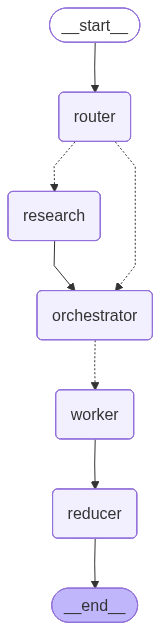

In [35]:
# -----------------------------
# 9) Build graph
# -----------------------------
g = StateGraph(State)
g.add_node("router", router_node)
g.add_node("research", research_node)
g.add_node("orchestrator", orchestrator_node)
g.add_node("worker", worker_node)
g.add_node("reducer", reducer_node)

g.add_edge(START, "router")
g.add_conditional_edges("router", route_next, {"research": "research", "orchestrator": "orchestrator"})
g.add_edge("research", "orchestrator")

g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

app = g.compile()

app


In [36]:
# -----------------------------
# 10) Runner
# -----------------------------
def run(topic: str, as_of: Optional[str] = None):
    if as_of is None:
        as_of = date.today().isoformat()

    out = app.invoke(
        {
            "topic": topic,
            "mode": "",
            "needs_research": False,
            "queries": [],
            "evidence": [],
            "plan": None,
            "as_of": as_of,
            "recency_days": 7,   # router may overwrite
            "sections": [],
            "final": "",
        }
    )

    plan: Plan = out["plan"]
    print("\n" + "=" * 100)
    print("TOPIC:", topic)
    print("AS_OF:", out.get("as_of"), "RECENCY_DAYS:", out.get("recency_days"))
    print("MODE:", out.get("mode"))
    print("BLOG_KIND:", plan.blog_kind)
    print("NEEDS_RESEARCH:", out.get("needs_research"))
    print("QUERIES:", (out.get("queries") or [])[:6])
    print("EVIDENCE_COUNT:", len(out.get("evidence", [])))
    if out.get("evidence"):
        print("EVIDENCE_SAMPLE:", [e.model_dump() for e in out["evidence"][:2]])
    print("TASKS:", len(plan.tasks))
    print("SAVED_MD_CHARS:", len(out.get("final", "")))
    print("=" * 100 + "\n")

    return out


In [37]:
run("Write a blog on Self Attention")

Successfully saved blog to: blogs\understanding_self-attention_the_mechanism_behind_modern_transformers.md

TOPIC: Write a blog on Self Attention
AS_OF: 2026-02-01 RECENCY_DAYS: 3650
MODE: closed_book
BLOG_KIND: explainer
NEEDS_RESEARCH: False
QUERIES: []
EVIDENCE_COUNT: 0
TASKS: 9
SAVED_MD_CHARS: 24034



{'topic': 'Write a blog on Self Attention',
 'mode': 'closed_book',
 'needs_research': False,
 'queries': [],
 'evidence': [],
 'plan': Plan(blog_title='Understanding Self-Attention: The Mechanism Behind Modern Transformers', audience='Software engineers and ML practitioners who want to understand the self-attention mechanism from first principles, including those implementing transformers or working with LLMs', tone='Technical but accessible, focusing on intuition first then diving into mechanics. Use clear analogies and concrete examples. Balance mathematical notation with practical implementation details.', blog_kind='explainer', constraints=[], tasks=[Task(id=1, title='The Problem Self-Attention Solves', goal='Readers should understand why recurrent and convolutional approaches were limiting and what specific computational problem self-attention addresses.', bullets=['Sequential bottleneck in RNNs: why processing tokens one-at-a-time creates training parallelization issues and long